# Federated PCA Demonstartion on 1000 Genomes Data

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import subprocess
import federated_pca

import pandas as pd
import matplotlib.pyplot as plt

### [ 0 ] Create Data Folders

In [78]:
federated_pca.init()

# List of clients nodes
print(federated_pca.NODES)

['AFR', 'SAS', 'EUR', 'AMR', 'EAS']


### [ 1 ] Variants Pruning (Simulation)

In [ ]:
federated_pca.prune(portion=0.001)

In [80]:
variant_ids_file = federated_pca.VARIANT_IDS_FOLDER + '/pruned.ids'

print('The number of ramaining variants')
!wc -l $variant_ids_file

The number of ramaining variants
856 /home/genxadmin/federated-pca/data/ids/pruned.ids


### [ 2 ] Compute Allele Frequencies for ALL Data

Summarized allele frequencies are used by plink on each client node for better plink PCA results.

In [ ]:
federated_pca.compute_allele_frequencies(federated_pca.ALL, variant_ids_file=variant_ids_file)

### [ 3 ] Run Local PCA on Each Client

In [ ]:
allele_frequencies_file = federated_pca.PCA_FOLDER + '/ALL.acount'
for node in federated_pca.NODES:
    federated_pca.client(
        node=node,
        variant_ids_file=variant_ids_file,
        allele_frequencies_file=allele_frequencies_file
    )

### [ 4 ] Aggregate the Results on the Server to Compute the Joint PCA

In [ ]:
evectors, evalues = federated_pca.server(federated_pca.NODES, n_components=2)
federated_pca.create_plink_eigenvec_allele_file(evectors, n_components=2)

### [ 5 ] Project the Client Feature Space onto Result Eigenvectors

In [ ]:
plink_allele_projector = federated_pca.PCA_FOLDER + '/federated.eigenvec.allele'
for node in federated_pca.NODES:
    federated_pca.client_projection(
        node=node,
        variant_ids_file=variant_ids_file,
        allele_frequencies_file=allele_frequencies_file,
        plink_allele_projector=plink_allele_projector,
        n_components=2
    )

### [ 6 ] Plot Projections Results for All Nodes

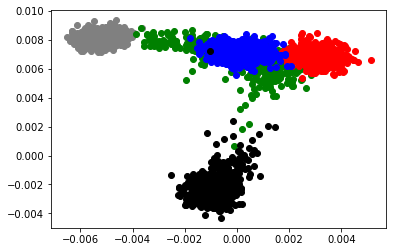

In [108]:
colors = {
    'AFR': 'black',
    'SAS': 'blue',
    'EUR': 'red',
    'AMR': 'green',
    'EAS': 'grey'
}

for node in federated_pca.NODES[::-1]:
    evectors = federated_pca.read_evectors_from_sscore(node)
    plt.scatter(-evectors.iloc[:, [0]], evectors.iloc[:, [1]], c=colors[node])

plt.show()

### [ * ] Centralized PCA with Plink

In [ ]:
subprocess.run([
    'plink2', '--pfile', federated_pca.SOURCE_FOLDER + '/ALL_filtered',
    '--extract', federated_pca.VARIANT_IDS_FOLDER + '/pruned.ids',
    '--read-freq', federated_pca.PCA_FOLDER + '/ALL.acount',
    '--pca', 'allele-wts', '2',
    '--out', federated_pca.PCA_FOLDER + '/ALL'
])

subprocess.run([
    'plink2', '--pfile', federated_pca.SOURCE_FOLDER + '/ALL_filtered',
    '--extract', federated_pca.VARIANT_IDS_FOLDER + '/pruned.ids',
    '--read-freq', federated_pca.PCA_FOLDER + '/ALL.acount',
    '--score', federated_pca.PCA_FOLDER + '/ALL.eigenvec.allele', '2', '5',
    '--score-col-nums', '6-7',
    '--out', federated_pca.PCA_FOLDER + '/ALL.projection'
])

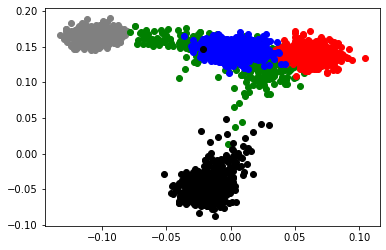

In [54]:
samples = pd.read_csv('/media/storage/TG/data/chip/igsr_samples.tsv', sep='\t', header=0)
samples.head()


input_sscore_file = federated_pca.PCA_FOLDER +  '/ALL.projection.sscore'
sscore = pd.read_csv(input_sscore_file, sep='\t', header=0)
codes = pd.merge(sscore, samples, left_on='#IID', right_on='Sample name')['Superpopulation code'].to_numpy()

evectors = sscore[sscore.columns[3:]]
for node in federated_pca.NODES[::-1]:
    selector = (codes == node)
    plt.scatter(evectors.iloc[selector, [1]], evectors.iloc[selector, [0]], c=colors[node])

### [ * ] All in Once

In [ ]:
import os
import time


n_components = 10
portions = [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]
ns_variants = []
elapsed_times = []
communication_costs = [] # FIXME: how to measure it?

for iteration, portion in enumerate(portions):
    print(f'MEASUREMENT {iteration + 1} OF {len(portions)}')

    federated_pca.prune(portion=portion)
    variant_ids_file = federated_pca.VARIANT_IDS_FOLDER + '/pruned.ids'
    n_variants = pd.read_csv(variant_ids_file, sep='\t', header=None).shape[0]
    ns_variants.append(n_variants)

    total_time = 0
    start = time.time()

    federated_pca.compute_allele_frequencies(federated_pca.ALL, variant_ids_file=variant_ids_file)
    allele_frequencies_file = federated_pca.PCA_FOLDER + '/ALL.acount'
    for node in federated_pca.NODES:
        federated_pca.client(
            node=node,
            variant_ids_file=variant_ids_file,
            allele_frequencies_file=allele_frequencies_file
        )

    evectors, evalues = federated_pca.server(federated_pca.NODES, n_components=n_components)
    federated_pca.create_plink_eigenvec_allele_file(evectors, n_components=n_components)

    plink_allele_projector = federated_pca.PCA_FOLDER + '/federated.eigenvec.allele'
    for node in federated_pca.NODES:
        federated_pca.client_projection(
            node=node,
            variant_ids_file=variant_ids_file,
            allele_frequencies_file=allele_frequencies_file,
            plink_allele_projector=plink_allele_projector,
            n_components=n_components
        )

    end = time.time()
    elapsed = end - start
    elapsed_times.append(elapsed)

    # Communication costs (Mb)
    cost = 0

    # [1] Alleles counts aggregation (approximation)
    acount_file = os.path.join(federated_pca.PCA_FOLDER, federated_pca.ALL + '.acount')
    cost += 6 * os.path.getsize(acount_file) / 1024 / 1024
    
    # [2] Local PCA results
    for node in federated_pca.NODES:
        eigenval_file = os.path.join(federated_pca.PCA_FOLDER, node + '.eigenval')
        eigenvec_allele_file = os.path.join(federated_pca.PCA_FOLDER, node + '.eigenvec.allele')

        cost += os.path.getsize(eigenval_file) / 1024 / 1024
        cost += os.path.getsize(eigenvec_allele_file) / 1024 / 1024

    # [3] Result PCA projection file to clients
    federated_eigenvec_allele_file = os.path.join(federated_pca.PCA_FOLDER, 'federated.eigenvec.allele')
    cost += os.path.getsize(federated_eigenvec_allele_file) / 1024 / 1024
    
    communication_costs.append(cost)

Text(0, 0.5, 'time [sec]')

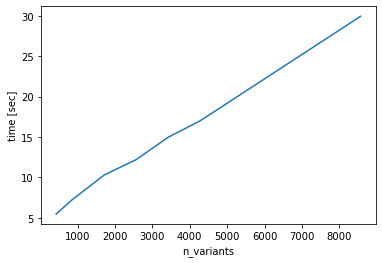

In [76]:
plt.plot(ns_variants, elapsed_times)
plt.xlabel('n_variants')
plt.ylabel('time [sec]')

Text(0, 0.5, 'communication_costs [Mb]')

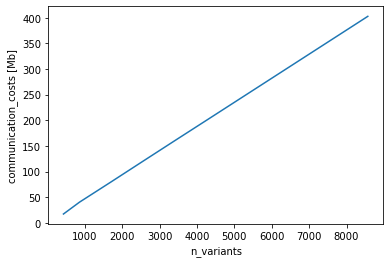

In [96]:
plt.plot(ns_variants, communication_costs)
plt.xlabel('n_variants')
plt.ylabel('communication_costs [Mb]')